# Support Vector Regression

### Imports

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from multiprocessing import Pool

df1 = pd.read_csv("../data/df_prepared.csv", index_col=0)

In [3]:
df1.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,days_left_binned,duration_sqrt,price
0,-1.368800,-1.732372,0.198274,-2.4911,0.236474,0.37094,-0.674351,2.375914,-1.742522,5953.0
1,-1.368800,-1.732372,-0.298600,-2.4911,0.445839,0.37094,-0.674351,2.375914,-1.691940,5953.0
2,-1.562898,-1.732372,-0.298600,-2.4911,-2.002790,0.37094,-0.674351,2.375914,-1.742522,5956.0
3,0.885018,-1.732372,0.469739,-2.4911,-0.820969,0.37094,-0.674351,2.375914,-1.717006,5955.0
4,0.885018,-1.732372,0.469739,-2.4911,0.445839,0.37094,-0.674351,2.375914,-1.691940,5955.0


### Identifying Correlation

Determining the correlation between features to identify the most correlated one across the board as the dependent variable.

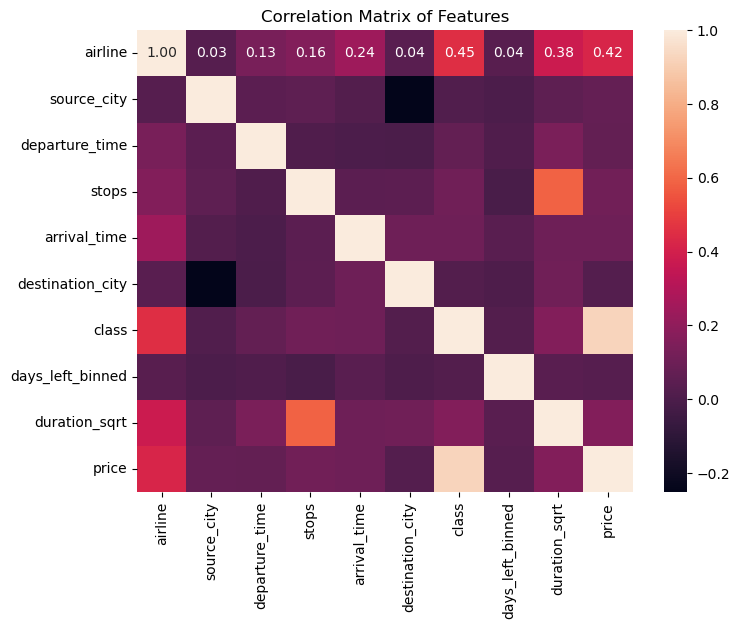

In [4]:
correlation_matrix = df1.corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

From the graph, we can determine that price_boxcox_scaled is the most correlated with other variables. Thus, it will be used as the dependent variable.

### Train Test Split

In [5]:
X = df1[['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class', 'days_left_binned', 'duration_sqrt']]
y = df1['price']

We will divide the dataset into Train:Test ratio of 0.8:0.2.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

<i>Question: Should I include validation set?</i>

### Regularization *

<i>Question: Do I need to regularise the data? Or has it already been done so in pre-processing stages?</i>

### Ordinary Least Squares

Performing OLS check to determine the significant independent variables for the model.

In [6]:
X_train_const = sm.add_constant(X_train)

ols_model = sm.OLS(y_train, X_train_const)
ols_results = ols_model.fit()

In [7]:
ols_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Ordinary least squares
===========================================================================
Model:                OLS                Adj. R-squared:       0.856       
Dependent Variable:   price              AIC:                  4957069.9881
Date:                 2024-03-15 19:13   BIC:                  4957173.7273
No. Observations:     236551             Log-Likelihood:       -2.4785e+06 
Df Model:             9                  F-statistic:          1.562e+05   
Df Residuals:         236541             Prob (F-statistic):   0.00        
R-squared:            0.856              Scale:                7.3860e+07  
---------------------------------------------------------------------------
                   Coef.    Std.Err.     t     P>|t|    [0.025     0.975]  
---------------------------------------------------------------------------
const            20633.6076  17.6708 1167.6653 0.0000 20598.9732 20668.2419
airline             33.1379  21.6417    1.5312 0.1257    -9.2792    75.5551
source_city       1420.2661  18.3404   77.4392 0.0000  1384.3193  1456.2128
departure_time      66.7745  17.9646    3.7170 0.0002    31.5644   101.9846
stops               68.0104  22.0246    3.0879 0.0020    24.8427   111.1780
arrival_time        -1.9158  18.3314   -0.1045 0.9168   -37.8448    34.0133
destination_city   494.7632  18.4894   26.7593 0.0000   458.5244   531.0019
class            20790.1763  19.7726 1051.4655 0.0000 20751.4226 20828.9300
days_left_binned   260.7314  17.7175   14.7161 0.0000   226.0057   295.4572
duration_sqrt      166.5463  23.7119    7.0237 0.0000   120.0716   213.0211
---------------------------------------------------------------------------
Omnibus:               53732.512        Durbin-Watson:           1.997     
Prob(Omnibus):         0.000            Jarque-Bera (JB):        666219.719
Skew:                  -0.744           Prob(JB):                0.000     
Kurtosis:              11.086           Condition No.:           2         
===========================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is
correctly specified.
"""

From here, we can determine that airline & arrival_time is not significant. And we will remove it from the independent variables.

In [8]:
new_X_train = X_train[['source_city', 'departure_time', 'stops', 'destination_city', 'class', 'days_left_binned', 'duration_sqrt']]
new_X_test = X_test[['source_city', 'departure_time', 'stops', 'destination_city', 'class', 'days_left_binned', 'duration_sqrt']]

In [9]:
new_X_train_const = sm.add_constant(new_X_train)

new_ols_model = sm.OLS(y_train, new_X_train_const)
new_ols_results = new_ols_model.fit()

In [10]:
new_ols_results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: Ordinary least squares
===========================================================================
Model:                OLS                Adj. R-squared:       0.856       
Dependent Variable:   price              AIC:                  4957068.3749
Date:                 2024-03-15 19:13   BIC:                  4957151.3663
No. Observations:     236551             Log-Likelihood:       -2.4785e+06 
Df Model:             7                  F-statistic:          2.008e+05   
Df Residuals:         236543             Prob (F-statistic):   0.00        
R-squared:            0.856              Scale:                7.3861e+07  
---------------------------------------------------------------------------
                   Coef.    Std.Err.     t     P>|t|    [0.025     0.975]  
---------------------------------------------------------------------------
const            20633.6650  17.6708 1167.6704 0.0000 20599.0307 20668.2993
source_city       1420.4210  18.3262   77.5077 0.0000  1384.5021  1456.3398
departure_time      68.6355  17.9164    3.8309 0.0001    33.5199   103.7512
stops               65.0668  21.9404    2.9656 0.0030    22.0643   108.0694
destination_city   494.5829  18.3915   26.8920 0.0000   458.5361   530.6298
class            20803.1246  17.9006 1162.1490 0.0000 20768.0399 20838.2092
days_left_binned   261.1576  17.7076   14.7483 0.0000   226.4512   295.8641
duration_sqrt      178.1681  22.4770    7.9267 0.0000   134.1138   222.2224
---------------------------------------------------------------------------
Omnibus:               53725.596        Durbin-Watson:           1.997     
Prob(Omnibus):         0.000            Jarque-Bera (JB):        666186.445
Skew:                  -0.744           Prob(JB):                0.000     
Kurtosis:              11.085           Condition No.:           2         
===========================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is
correctly specified.
"""

No visible improvement in R2 or Adj. R2 Scores. However, they are still quite high, and are identical. Implying that there is no substantial overfitting from the independent variables used.<br>
Thus, we can use keep the insignificant features.

### Variance Inflation Factor:

In [11]:
new_X_range = len(new_X_train_const.columns)

for i in range(1, new_X_range):
    v = vif(new_X_train_const.values, i)
    print("VIF for {}: {}".format(new_X_train_const.columns[i], round(v, 4)))

VIF for source_city: 1.0776
VIF for departure_time: 1.0311
VIF for stops: 1.552
VIF for destination_city: 1.0855
VIF for class: 1.0288
VIF for days_left_binned: 1.0033
VIF for duration_sqrt: 1.6202


All independent variables' VIF are small, and below 10. Thus, there is no multicolinearity among them.

### SVR Modelling

Training the model with pre-determined parameters.

In [26]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

Estimated run time for model fitting: 100-130 mins.

In [27]:
svr_rbf.fit(new_X_train, y_train)
    
y_pred = svr_rbf.predict(new_X_test)

In [30]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [31]:
print("Mean Absolute Error: " + str(mae))
print("Mean Squared Error: " + str(mse))
print("Root Mean Squared Error: " + str(rmse))
print("R2 Score: " + str(r2))

Mean Absolute Error: 0.24251893199215085
Mean Squared Error: 0.13413369675532666
Root Meam Squared Error: 0.3662426746780428
R2 Score: 0.8659482932966688


Inferences: <br>
<ul>
    <li>The current model explains about 86.63% of the variance in the dependent variable price_boxcox_scaled. (R2)</li>
    <li>The model's predictions are 0.2435 units from the actual values on average. (MAE)</li>
    <li>The average of the squares of the errors between the predicted and actual values is about 0.1337 units.</li>
    <li>The intepretable, actual average of the errors between the predicted and actual values is about 0.3657 units.</li>
</ul>

For comparison, we fit the model with the inclusion of the insignificant independent variable removed earlier.

In [ ]:
svr_rbf.fit(X_train, y_train)
    
old_y_pred = svr_rbf.predict(X_test)

In [ ]:
old_mae = mean_absolute_error(y_test, old_y_pred)
old_mse = mean_squared_error(y_test, old_y_pred)
old_rmse = np.sqrt(mse)
old_r2 = r2_score(y_test, old_y_pred)

In [ ]:
print("Mean Absolute Error: " + str(old_mae))
print("Mean Squared Error: " + str(old_mse))
print("Root Mean Squared Error: " + str(old_rmse))
print("R2 Score: " + str(old_r2))

Mean Absolute Error: 0.2434806249370293
Mean Squared Error: 0.13371570839006203
Root Meam Squared Error: 0.3656715854288682
R2 Score: 0.866260291096647


Compared to the optimized feature selection iteration, the older version is slightly better with a barely noticable difference.

Let's try this again with a different kernel type.

In [105]:
linear_svr_rbf = SVR(kernel='linear', C=100, gamma=0.1, epsilon=.1)

In [106]:
linear_svr_rbf.fit(X_train, y_train)
    
linear_y_pred = linear_svr_rbf.predict(X_test)

In [107]:
linear_mae = mean_absolute_error(y_test, linear_y_pred)
linear_mape = mean_absolute_percentage_error(y_test, linear_y_pred)
linear_mse = mean_squared_error(y_test, linear_y_pred)
linear_rmse = np.sqrt(linear_mse)
linear_r2 = r2_score(y_test, linear_y_pred)

print("Mean Absolute Error: " + str(linear_mae))
print("Mean Absolute Percentage Error: " + str(linear_mape))
print("Mean Squared Error: " + str(linear_mse))
print("Root Mean Squared Error: " + str(linear_rmse))
print("R2 Score: " + str(linear_r2))

Mean Absolute Error: 5026.833211343384
Mean Absolute Percentage Error: 0.4990828812589028
Mean Squared Error: 78105625.0652555
Root Mean Squared Error: 8837.738685051481
R2 Score: 0.8469837243757123


In [14]:
# Wtih Box_Cox Price

# Define parameter grid for grid search with rbf. It takes too long if I add too many parameters.
param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10],
    # 'gamma': [0.001, 0.01, 0.1],
    # 'epsilon': [0.01, 0.1]
}

# Custom function to print output of each iteration
def print_iteration_output(results):
    print("Iteration results:")
    print(results)

# Create SVR model
svr = SVR()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, refit=False)
grid_search.fit(X_train, y_train)

# Print output of each iteration
for i, params in enumerate(grid_search.cv_results_['params']):
    print(f"Iteration {i+1} - Params: {params}")
    print(f"Mean validation score: {grid_search.cv_results_['mean_test_score'][i]}")

# Print best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get best SVR model
best_svr = SVR(**grid_search.best_params_)

# Fit best model on full training data
best_svr.fit(X_train, y_train)

# Predictions on test set
gs_y_pred = best_svr.predict(X_test)

# Evaluate model performance
gs_mae = mean_absolute_error(y_test, gs_y_pred)
gs_mape = mean_absolute_percentage_error(y_test, gs_y_pred)
gs_mse = mean_squared_error(y_test, gs_y_pred)
gs_rmse = np.sqrt(gs_mse)
gs_r2 = r2_score(y_test, gs_y_pred)
print("Mean Absolute Error: " + str(gs_mae))
print("Mean Absolute Percentage Error: " + str(gs_mape))
print("Mean Squared Error: " + str(gs_mse))
print("Root Mean Squared Error: " + str(gs_rmse))
print("R2 Score: " + str(gs_r2))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Iteration 1 - Params: {'C': 0.1, 'kernel': 'rbf'}
Mean validation score: -0.13420495781998204
Iteration 2 - Params: {'C': 1, 'kernel': 'rbf'}
Mean validation score: -0.13275636672273847
Iteration 3 - Params: {'C': 10, 'kernel': 'rbf'}
Mean validation score: -0.1316063590756194
Best parameters found:  {'C': 10, 'kernel': 'rbf'}
Mean Absolute Error: 0.2395228419020061
Mean Absolute Percentage Error: 1.1841642194787199
Mean Squared Error: 0.1319164461924696
Root Mean Squared Error: 0.3632030371465382
R2 Score: 0.8677362260803554


Best parameters found:  {'C': 10, 'kernel': 'rbf'}<br>
Mean Absolute Error: 0.2395228419020061<br>
Mean Absolute Percentage Error: 1.1841642194787199<br>
Mean Squared Error: 0.1319164461924696<br>
Root Mean Squared Error: 0.3632030371465382<br>
R2 Score: 0.8677362260803554

In [41]:
# Without Box_Cox Price

# Define parameter grid for grid search with rbf. It takes too long if I add too many parameters.
param_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10],
    # 'gamma': [0.001, 0.01, 0.1],
    # 'epsilon': [0.01, 0.1]
}

# Custom function to print output of each iteration
def print_iteration_output(results):
    print("Iteration results:")
    print(results)

# Create SVR model
svr = SVR()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, refit=False)
grid_search.fit(X_train, y_train)

# Print output of each iteration
for i, params in enumerate(grid_search.cv_results_['params']):
    print(f"Iteration {i+1} - Params: {params}")
    print(f"Mean validation score: {grid_search.cv_results_['mean_test_score'][i]}")

# Print best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get best SVR model
best_svr = SVR(**grid_search.best_params_)

# Fit best model on full training data
best_svr.fit(X_train, y_train)

# Predictions on test set
gs_y_pred = best_svr.predict(X_test)

# Evaluate model performance
gs_mae = mean_absolute_error(y_test, gs_y_pred)
gs_mape = mean_absolute_percentage_error(y_test, gs_y_pred)
gs_mse = mean_squared_error(y_test, gs_y_pred)
gs_rmse = np.sqrt(gs_mse)
gs_r2 = r2_score(y_test, gs_y_pred)
print("Mean Absolute Error: " + str(gs_mae))
print("Mean Absolute Percentage Error: " + str(gs_mape))
print("Mean Squared Error: " + str(gs_mse))
print("Root Mean Squared Error: " + str(gs_rmse))
print("R2 Score: " + str(gs_r2))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Iteration 1 - Params: {'C': 0.1, 'kernel': 'rbf'}
Mean validation score: -648142579.3475331
Iteration 2 - Params: {'C': 1, 'kernel': 'rbf'}
Mean validation score: -354702119.3030982
Iteration 3 - Params: {'C': 10, 'kernel': 'rbf'}
Mean validation score: -98394595.04072435
Best parameters found:  {'C': 10, 'kernel': 'rbf'}
Mean Absolute Error: 5702.813804289118
Mean Absolute Percentage Error: 0.5020599766797174
Mean Squared Error: 92911170.29697773
Root Mean Squared Error: 9639.044055142487
R2 Score: 0.8179782668551777


In [103]:
# Without Box_Cox Price & Higher Hyperparameters & Epsilons.

# Define parameter grid for grid search with rbf. It takes too long if I add too many parameters.
param_grid = {
    'kernel': ['rbf'],
    'C': [40, 70 ,100],
    # 'gamma': [0.001, 0.01, 0.1],
    'epsilon': [0.01, 0.1]
}

# Custom function to print output of each iteration
def print_iteration_output(results):
    print("Iteration results:")
    print(results)

# Create SVR model
svr = SVR()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, refit=False)
grid_search.fit(X_train, y_train)

# Print output of each iteration
for i, params in enumerate(grid_search.cv_results_['params']):
    print(f"Iteration {i+1} - Params: {params}")
    print(f"Mean validation score: {grid_search.cv_results_['mean_test_score'][i]}")

# Print best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get best SVR model
new_best_svr = SVR(**grid_search.best_params_)

# Fit best model on full training data
new_best_svr.fit(X_train, y_train)

# Predictions on test set
new_gs_y_pred = best_svr.predict(X_test)

# Evaluate model performance
new_gs_mae = mean_absolute_error(y_test, new_gs_y_pred)
new_gs_mape = mean_absolute_percentage_error(y_test, new_gs_y_pred)
new_gs_mse = mean_squared_error(y_test, new_gs_y_pred)
new_gs_rmse = np.sqrt(new_gs_mse)
new_gs_r2 = r2_score(y_test, new_gs_y_pred)
print("Mean Absolute Error: " + str(new_gs_mae))
print("Mean Absolute Percentage Error: " + str(new_gs_mape))
print("Mean Squared Error: " + str(new_gs_mse))
print("Root Mean Squared Error: " + str(new_gs_rmse))
print("R2 Score: " + str(new_gs_r2))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Iteration 1 - Params: {'C': 40, 'epsilon': 0.01, 'kernel': 'rbf'}
Mean validation score: -76891653.22173436
Iteration 2 - Params: {'C': 40, 'epsilon': 0.1, 'kernel': 'rbf'}
Mean validation score: -76891627.6252309
Iteration 3 - Params: {'C': 70, 'epsilon': 0.01, 'kernel': 'rbf'}
Mean validation score: -73090374.94506846
Iteration 4 - Params: {'C': 70, 'epsilon': 0.1, 'kernel': 'rbf'}
Mean validation score: -73090352.37180713
Iteration 5 - Params: {'C': 100, 'epsilon': 0.01, 'kernel': 'rbf'}
Mean validation score: -71399919.2858651
Iteration 6 - Params: {'C': 100, 'epsilon': 0.1, 'kernel': 'rbf'}
Mean validation score: -71399921.10597666
Best parameters found:  {'C': 100, 'epsilon': 0.01, 'kernel': 'rbf'}
Mean Absolute Error: 5702.813804289118
Mean Absolute Percentage Error: 0.5020599766797174
Mean Squared Error: 92911170.29697773
Root Mean Squared Error: 9639.044055142487
R2 Score: 0.8179782668551777


In [112]:
# Try all

# Define parameter grid for grid search with rbf. It takes too long if I add too many parameters.
param_grid = {
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'C': [100],
    # 'gamma': [0.001, 0.01, 0.1],
    'epsilon': [0.01]
}

# Custom function to print output of each iteration
def print_iteration_output(results):
    print("Iteration results:")
    print(results)

# Create SVR model
svr = SVR()

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, refit=False)
grid_search.fit(X_train, y_train)

# Print output of each iteration
for i, params in enumerate(grid_search.cv_results_['params']):
    print(f"Iteration {i+1} - Params: {params}")
    print(f"Mean validation score: {grid_search.cv_results_['mean_test_score'][i]}")

# Print best parameters
print("Best parameters found: ", grid_search.best_params_)

# Get best SVR model
all_best_svr = SVR(**grid_search.best_params_)

# Fit best model on full training data
all_best_svr.fit(X_train, y_train)

# Predictions on test set
all_gs_y_pred = best_svr.predict(X_test)

# Evaluate model performance
all_gs_mae = mean_absolute_error(y_test, all_gs_y_pred)
all_gs_mape = mean_absolute_percentage_error(y_test, all_gs_y_pred)
all_gs_mse = mean_squared_error(y_test, all_gs_y_pred)
all_gs_rmse = np.sqrt(all_gs_mse)
all_gs_r2 = r2_score(y_test, all_gs_y_pred)
print("Mean Absolute Error: " + str(all_gs_mae))
print("Mean Absolute Percentage Error: " + str(all_gs_mape))
print("Mean Squared Error: " + str(all_gs_mse))
print("Root Mean Squared Error: " + str(all_gs_rmse))
print("R2 Score: " + str(all_gs_r2))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Iteration 1 - Params: {'C': 100, 'epsilon': 0.01, 'kernel': 'rbf'}
Mean validation score: -73740744.73313455
Iteration 2 - Params: {'C': 100, 'epsilon': 0.01, 'kernel': 'linear'}
Mean validation score: -75781416.9495543
Iteration 3 - Params: {'C': 100, 'epsilon': 0.01, 'kernel': 'poly'}
Mean validation score: -82927702.67811835
Iteration 4 - Params: {'C': 100, 'epsilon': 0.01, 'kernel': 'sigmoid'}
Mean validation score: -4557291276.851978
Best parameters found:  {'C': 100, 'epsilon': 0.01, 'kernel': 'rbf'}
Mean Absolute Error: 5702.813804289118
Mean Absolute Percentage Error: 0.5020599766797174
Mean Squared Error: 92911170.29697773
Root Mean Squared Error: 9639.044055142487
R2 Score: 0.8179782668551777


In [70]:
pca = PCA(n_components=1)

# Fit and transform the data
X_pca = pca.fit_transform(X_test)

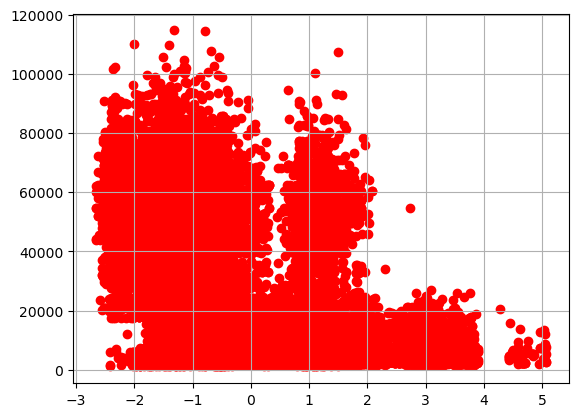

In [72]:
# Create scatter plot
plt.scatter(X_pca, y_test, color='red', label='Scatter Plot')

# # Create line plot
# plt.plot(X_pca, gs_y_pred, color='blue', label='Line Plot')

# # Add labels and title
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('Scatter and Line Plot')

# # Add legend
# plt.legend()

# Show plot
plt.grid(True)
plt.show()

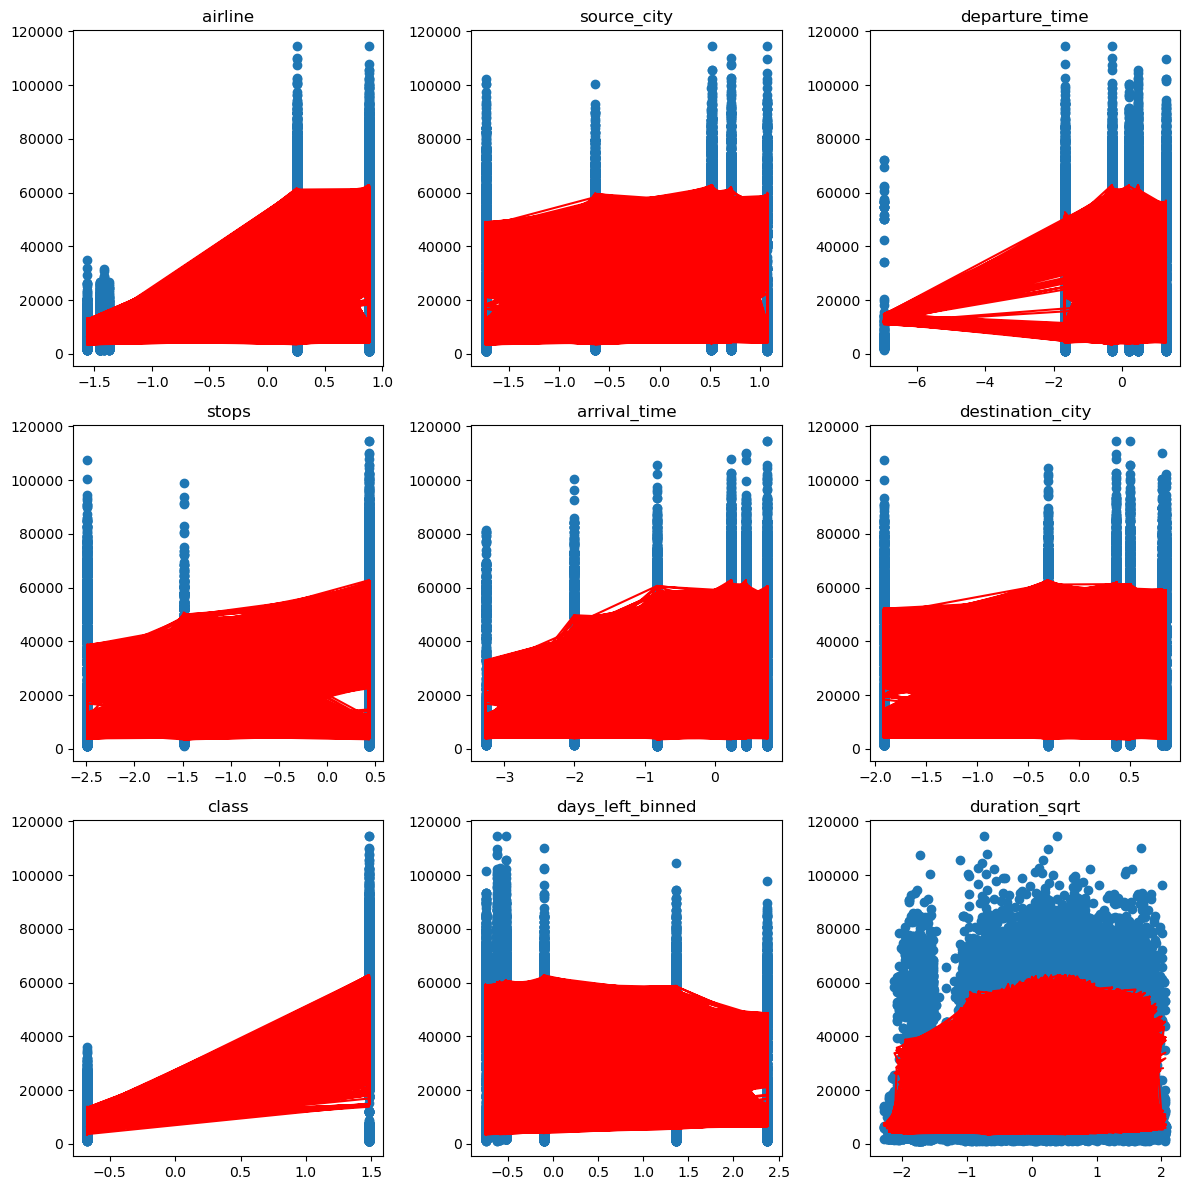

In [104]:
# Create figure and subplots
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Plot each column separately
for i, col in enumerate(X_train.columns):
    ax = axs[i // 3, i % 3]  # Calculate subplot position
    ax.scatter(X_test[col], y_test)
    ax.plot(X_test[col], new_gs_y_pred, color='red')
    ax.set_title(col)

plt.tight_layout()
plt.show()

In [76]:
y_test.min()

1105.0

### Tuning

We will use this SVR template function to fit your various combination of parameters in.

In [7]:
def evaluate_svr(kernel, C, epsilon, X_train, y_train, X_test, y_test):
    # Initialize SVR model with current parameters
    current_svr = SVR(kernel=kernel, C=C, epsilon=epsilon)
    
    # Fit SVR model on full training data
    current_svr.fit(X_train, y_train)
    
    # Predictions on test set
    y_pred = current_svr.predict(X_test)

    # Parameters
    print("Kernel:", current_svr.kernel)
    print("C:", current_svr.C)
    print("Epsilon:", current_svr.epsilon)
    
    # Calculate evaluation metrics
    r2 = r2_score(y_test, y_pred)
    adjusted_r2 = 1 - (1 - r2) * (len(X_test) - 1) / (len(X_test) - len(X_test.columns) - 1)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print("R2:", r2)
    print("Adjusted R2:", adjusted_r2)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("MAPE:", mape)
    
    return {'Kernel': kernel, 'C': C, 'Epsilon': epsilon,
            'R2': r2, 'Adjusted_R2': adjusted_r2,
            'MSE': mse, 'RMSE': rmse,
            'MAE': mae, 'MAPE': mape}

Combinations are tested individually as running nested for loops exhausts my hardware and ends up running indefinitely. <br>
Grid Search was considered, but was not opted for as it was unable to show and compare the results of each combination, only the best fitted one. <br>
We will use RBF kernel as a control first.

In [16]:
tune1 = evaluate_svr('rbf', 90, 0.001, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 90
Epsilon: 0.001
R2: 0.8607440162657682
Adjusted R2: 0.860722819813096
MSE: 70761496.2041963
RMSE: 8411.9852712779
MAE: 4865.904172806014
MAPE: 0.4490452081786026


In [14]:
tune2 = evaluate_svr('rbf', 90, 0.01, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 90
Epsilon: 0.01
R2: 0.8609363714701596
Adjusted R2: 0.8609152042962864
MSE: 70663752.88501969
RMSE: 8406.173498389127
MAE: 4862.55647318859
MAPE: 0.44775498981257034


In [17]:
tune3 = evaluate_svr('rbf', 90, 0.1, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 90
Epsilon: 0.1
R2: 0.8609363633920171
Adjusted R2: 0.8609151962169144
MSE: 70663756.9898447
RMSE: 8406.173742544504
MAE: 4862.557119465351
MAPE: 0.44775467289332893


In [18]:
tune4 = evaluate_svr('rbf', 100, 0.001, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 100
Epsilon: 0.001
R2: 0.8616274254076313
Adjusted R2: 0.8616063634205637
MSE: 70312600.9326079
RMSE: 8385.260934079983
MAE: 4844.948945468808
MAPE: 0.44661079389770114


In [19]:
tune5 = evaluate_svr('rbf', 100, 0.01, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 100
Epsilon: 0.01
R2: 0.8616274216086772
Adjusted R2: 0.8616063596210314
MSE: 70312602.86300732
RMSE: 8385.261049186682
MAE: 4844.948779634918
MAPE: 0.4466107405967718


In [20]:
tune6 = evaluate_svr('rbf', 100, 0.1, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 100
Epsilon: 0.1
R2: 0.8616273752196051
Adjusted R2: 0.8616063132248983
MSE: 70312626.43513733
RMSE: 8385.262454755804
MAE: 4844.947019405328
MAPE: 0.4466100720267404


In [21]:
tune7 = evaluate_svr('rbf', 110, 0.001, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 110
Epsilon: 0.001
R2: 0.8622133363278234
Adjusted R2: 0.8621923635235167
MSE: 70014876.32327047
RMSE: 8367.489248470563
MAE: 4830.386722214043
MAPE: 0.4455277200786634


In [22]:
tune8 = evaluate_svr('rbf', 110, 0.01, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 110
Epsilon: 0.01
R2: 0.8622133371638044
Adjusted R2: 0.862192364359625
MSE: 70014875.89847532
RMSE: 8367.489223086894
MAE: 4830.386632027131
MAPE: 0.44552777501362456


In [23]:
tune9 = evaluate_svr('rbf', 110, 0.1, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 110
Epsilon: 0.1
R2: 0.86221332880628
Adjusted R2: 0.8621923560008283
MSE: 70014880.14526543
RMSE: 8367.48947685418
MAE: 4830.386317420298
MAPE: 0.4455281294233293


In [27]:
tune_dict = {
    '0': tune1,
    '1': tune2,
    '2': tune3,
    '3': tune4,
    '4': tune5,
    '5': tune6,
    '6': tune7,
    '7': tune8,
    '8': tune9
}

tune_df = pd.DataFrame(tune_dict)
tune_df = tune_df.T
tune_df.head(9)

,Kernel,C,Epsilon,R2,Adjusted_R2,MSE,RMSE,MAE,MAPE
0,rbf,90,0.001,0.860744,0.860723,70761496.204196,8411.985271,4865.904173,0.449045
1,rbf,90,0.01,0.860936,0.860915,70663752.88502,8406.173498,4862.556473,0.447755
2,rbf,90,0.1,0.860936,0.860915,70663756.989845,8406.173743,4862.557119,0.447755
3,rbf,100,0.001,0.861627,0.861606,70312600.932608,8385.260934,4844.948945,0.446611
4,rbf,100,0.01,0.861627,0.861606,70312602.863007,8385.261049,4844.94878,0.446611
5,rbf,100,0.1,0.861627,0.861606,70312626.435137,8385.262455,4844.947019,0.44661
6,rbf,110,0.001,0.862213,0.862192,70014876.32327,8367.489248,4830.386722,0.445528
7,rbf,110,0.01,0.862213,0.862192,70014875.898475,8367.489223,4830.386632,0.445528
8,rbf,110,0.1,0.862213,0.862192,70014880.145265,8367.489477,4830.386317,0.445528


In [45]:
# Sort the tune_df DataFrame by Adjusted_R2 in descending order
tune_df_sorted = tune_df[['Kernel', 'C', 'Epsilon', 'Adjusted_R2']].sort_values(by='Adjusted_R2', ascending=False)

# Get the tune with the highest Adjusted_R2
tune_highest_adjusted_r2 = tune_df_sorted.iloc[0]

# Sort the tune_df DataFrame by RMSE in ascending order
tune_df_sorted = tune_df[['Kernel', 'C', 'Epsilon', 'RMSE']].sort_values(by='RMSE', ascending=True)

# Get the tune with the lowest RMSE
tune_lowest_rmse = tune_df_sorted.iloc[0]

# Sort the tune_df DataFrame by MAPE in ascending order
tune_df_sorted = tune_df[['Kernel', 'C', 'Epsilon', 'MAPE']].sort_values(by='MAPE', ascending=True)

# Get the tune with the lowest MAPE
tune_lowest_mape = tune_df_sorted.iloc[0]

print("Highest Adjusted R2:\n", tune_highest_adjusted_r2, "\n")
print("Lowest RMSE:\n", tune_lowest_rmse, "\n")
print("Lowest MAPE:\n", tune_lowest_mape, "\n")


Highest Adjusted R2:
 Kernel              rbf
C                   110
Epsilon            0.01
Adjusted_R2    0.862192
Name: 7, dtype: object 

Lowest RMSE:
 Kernel             rbf
C                  110
Epsilon           0.01
RMSE       8367.489223
Name: 7, dtype: object 

Lowest MAPE:
 Kernel          rbf
C               110
Epsilon       0.001
MAPE       0.445528
Name: 6, dtype: object 



For now it seems as though the higher the C, the better the scores. <br>
However, the MAPE prefers a lower Epsilon value, while the Adjusted R2 is working with a higher one. <br>
RMSE also worsens when Epsilon 0.1 is used.

Proceed to further tune the C with larger values, and Eplison within the range of 0.01 to 0.1. <br>
The results will be added onto the tunes_df. <br>
We will observe the fitting of bins of 3. With C: 120 to 160, and Eplison: 0.01 to 0.1.

Second round of tuning with new parameters.

In [46]:
next_tune1 = evaluate_svr('rbf', 120, 0.001, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 120
Epsilon: 0.001
R2: 0.862714720337839
Adjusted R2: 0.8626938238502704
MSE: 69760103.19417267
RMSE: 8352.251384756846
MAE: 4818.039850933099
MAPE: 0.4447137439242315


In [47]:
next_tune2 = evaluate_svr('rbf', 120, 0.004, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 120
Epsilon: 0.004
R2: 0.8627147193990943
Adjusted R2: 0.8626938229113827
MSE: 69760103.67118618
RMSE: 8352.251413312832
MAE: 4818.039834411187
MAPE: 0.4447137260166029


In [48]:
next_tune3 = evaluate_svr('rbf', 120, 0.007, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 120
Epsilon: 0.007
R2: 0.8627147194605413
Adjusted R2: 0.8626938229728391
MSE: 69760103.63996245
RMSE: 8352.25141144365
MAE: 4818.0398283451295
MAPE: 0.4447136936250691


In [49]:
next_tune4 = evaluate_svr('rbf', 120, 0.01, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 120
Epsilon: 0.01
R2: 0.8627147179346057
Adjusted R2: 0.8626938214466713
MSE: 69760104.41535094
RMSE: 8352.251457861583
MAE: 4818.039822014875
MAPE: 0.44471367977828846


In [50]:
next_tune5 = evaluate_svr('rbf', 140, 0.001, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 140
Epsilon: 0.001
R2: 0.8635750219147837
Adjusted R2: 0.8635542563755677
MSE: 69322949.79408883
RMSE: 8326.04046315467
MAE: 4797.54678719618
MAPE: 0.44310010493811375


In [51]:
next_tune6 = evaluate_svr('rbf', 140, 0.004, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 140
Epsilon: 0.004
R2: 0.8635750240967301
Adjusted R2: 0.8635542585578462
MSE: 69322948.6853552
RMSE: 8326.040396572384
MAE: 4797.5467873372545
MAPE: 0.4431001337056642


In [52]:
next_tune7 = evaluate_svr('rbf', 140, 0.007, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 140
Epsilon: 0.007
R2: 0.8635750259304076
Adjusted R2: 0.8635542603918027
MSE: 69322947.75359088
RMSE: 8326.040340617554
MAE: 4797.546790463158
MAPE: 0.4431001618059727


In [53]:
next_tune8 = evaluate_svr('rbf', 140, 0.01, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 140
Epsilon: 0.01
R2: 0.8635750277801221
Adjusted R2: 0.8635542622417988
MSE: 69322946.81367747
RMSE: 8326.040284173352
MAE: 4797.546796151698
MAPE: 0.443100189710505


In [54]:
next_tune9 = evaluate_svr('rbf', 160, 0.001, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 160
Epsilon: 0.001
R2: 0.864299011961666
Adjusted R2: 0.8642783566225315
MSE: 68955061.69635284
RMSE: 8303.91845434147
MAE: 4781.418428348253
MAPE: 0.4415844929034858


In [55]:
next_tune10 = evaluate_svr('rbf', 160, 0.004, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 160
Epsilon: 0.004
R2: 0.8642990098579363
Adjusted R2: 0.8642783545184816
MSE: 68955062.76534149
RMSE: 8303.91851870799
MAE: 4781.418446682779
MAPE: 0.4415844758995709


In [56]:
next_tune11 = evaluate_svr('rbf', 160, 0.007, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 160
Epsilon: 0.007
R2: 0.8642990072362635
Adjusted R2: 0.8642783518964098
MSE: 68955064.09751755
RMSE: 8303.91859892169
MAE: 4781.418473126304
MAPE: 0.4415844571725034


In [57]:
next_tune12 = evaluate_svr('rbf', 160, 0.01, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 160
Epsilon: 0.01
R2: 0.8642990046574134
Adjusted R2: 0.8642783493171671
MSE: 68955065.40793371
RMSE: 8303.91867782517
MAE: 4781.418487191129
MAPE: 0.441584435239143


In [58]:
next_tune_dict = {
    '0': next_tune1,
    '1': next_tune2,
    '2': next_tune3,
    '3': next_tune4,
    '4': next_tune5,
    '5': next_tune6,
    '6': next_tune7,
    '7': next_tune8,
    '8': next_tune9,
    '9': next_tune10,
    '10': next_tune11,
    '11': next_tune12
}

next_tune_df = pd.DataFrame(next_tune_dict)
next_tune_df = next_tune_df.T
next_tune_df.head(12)

,Kernel,C,Epsilon,R2,Adjusted_R2,MSE,RMSE,MAE,MAPE
0,rbf,120,0.001,0.862715,0.862694,69760103.194173,8352.251385,4818.039851,0.444714
1,rbf,120,0.004,0.862715,0.862694,69760103.671186,8352.251413,4818.039834,0.444714
2,rbf,120,0.007,0.862715,0.862694,69760103.639962,8352.251411,4818.039828,0.444714
3,rbf,120,0.01,0.862715,0.862694,69760104.415351,8352.251458,4818.039822,0.444714
4,rbf,140,0.001,0.863575,0.863554,69322949.794089,8326.040463,4797.546787,0.4431
5,rbf,140,0.004,0.863575,0.863554,69322948.685355,8326.040397,4797.546787,0.4431
6,rbf,140,0.007,0.863575,0.863554,69322947.753591,8326.040341,4797.54679,0.4431
7,rbf,140,0.01,0.863575,0.863554,69322946.813677,8326.040284,4797.546796,0.4431
8,rbf,160,0.001,0.864299,0.864278,68955061.696353,8303.918454,4781.418428,0.441584
9,rbf,160,0.004,0.864299,0.864278,68955062.765341,8303.918519,4781.418447,0.441584


In [59]:
# Sort the tune_df DataFrame by Adjusted_R2 in descending order
next_tune_df_sorted = next_tune_df[['Kernel', 'C', 'Epsilon', 'Adjusted_R2']].sort_values(by='Adjusted_R2', ascending=False)

# Get the tune with the highest Adjusted_R2
next_tune_highest_adjusted_r2 = next_tune_df_sorted.iloc[0]

# Sort the tune_df DataFrame by RMSE in ascending order
next_tune_df_sorted = next_tune_df[['Kernel', 'C', 'Epsilon', 'RMSE']].sort_values(by='RMSE', ascending=True)

# Get the tune with the lowest RMSE
next_tune_lowest_rmse = next_tune_df_sorted.iloc[0]

# Sort the tune_df DataFrame by MAPE in ascending order
next_tune_df_sorted = next_tune_df[['Kernel', 'C', 'Epsilon', 'MAPE']].sort_values(by='MAPE', ascending=True)

# Get the tune with the lowest MAPE
next_tune_lowest_mape = next_tune_df_sorted.iloc[0]

print("Highest Adjusted R2:\n", next_tune_highest_adjusted_r2, "\n")
print("Lowest RMSE:\n", next_tune_lowest_rmse, "\n")
print("Lowest MAPE:\n", next_tune_lowest_mape, "\n")

Highest Adjusted R2:
 Kernel              rbf
C                   160
Epsilon           0.001
Adjusted_R2    0.864278
Name: 8, dtype: object 

Lowest RMSE:
 Kernel             rbf
C                  160
Epsilon          0.001
RMSE       8303.918454
Name: 8, dtype: object 

Lowest MAPE:
 Kernel          rbf
C               160
Epsilon        0.01
MAPE       0.441584
Name: 11, dtype: object 



Here, we find that 0.001 is the best Epsilon value, resulting in the lowest RMSE score of the range tested. <br>
And, a higher C still proves to result in a better scores across the board.

In [60]:
next2_tune1 = evaluate_svr('rbf', 200, 0.001, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 200
Epsilon: 0.001
R2: 0.8653287910058052
Adjusted R2: 0.8653082924115529
MSE: 68431790.06400362
RMSE: 8272.350939364433
MAE: 4756.098715581897
MAPE: 0.4391850465549672


In [61]:
next2_tune2 = evaluate_svr('rbf', 240, 0.001, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 240
Epsilon: 0.001
R2: 0.8661198405452635
Adjusted R2: 0.8660994623583623
MSE: 68029826.37466913
RMSE: 8248.019542573184
MAE: 4737.339401286908
MAPE: 0.43730584091949753


In [62]:
next2_tune3 = evaluate_svr('rbf', 240, 0.001, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 240
Epsilon: 0.001
R2: 0.8661198405452635
Adjusted R2: 0.8660994623583623
MSE: 68029826.37466913
RMSE: 8248.019542573184
MAE: 4737.339401286908
MAPE: 0.43730584091949753


In [63]:
next2_tune4 = evaluate_svr('rbf', 280, 0.001, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 280
Epsilon: 0.001
R2: 0.8667822689505873
Adjusted R2: 0.8667619915933379
MSE: 67693220.19206998
RMSE: 8227.588965916442
MAE: 4722.660520798381
MAPE: 0.435581599162979


In [64]:
next2_tune5 = evaluate_svr('rbf', 320, 0.001, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 320
Epsilon: 0.001
R2: 0.867341253469053
Adjusted R2: 0.8673210611960389
MSE: 67409177.9568932
RMSE: 8210.309248554113
MAE: 4710.254967048092
MAPE: 0.4340617735059864


In [65]:
next2_tune6 = evaluate_svr('rbf', 360, 0.001, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 360
Epsilon: 0.001
R2: 0.8678159901741312
Adjusted R2: 0.8677958701618117
MSE: 67167945.38179249
RMSE: 8195.605248045595
MAE: 4699.7420225579
MAPE: 0.4328113991915857


In [66]:
next2_tune7 = evaluate_svr('rbf', 400, 0.001, X_train, y_train, X_test, y_test)

Kernel: rbf
C: 400
Epsilon: 0.001
R2: 0.8682223873493188
Adjusted R2: 0.8682023291955869
MSE: 66961438.83608949
RMSE: 8182.996934869858
MAE: 4691.047154777088
MAPE: 0.43158810150167304


In [67]:
next2_tune_dict = {
    '0': next2_tune1,
    '1': next2_tune2,
    '2': next2_tune3,
    '3': next2_tune4,
    '4': next2_tune5,
    '5': next2_tune6,
    '6': next2_tune7,
}

next2_tune_df = pd.DataFrame(next2_tune_dict)
next2_tune_df = next2_tune_df.T
next2_tune_df.head(12)

,Kernel,C,Epsilon,R2,Adjusted_R2,MSE,RMSE,MAE,MAPE
0,rbf,200,0.001,0.865329,0.865308,68431790.064004,8272.350939,4756.098716,0.439185
1,rbf,240,0.001,0.86612,0.866099,68029826.374669,8248.019543,4737.339401,0.437306
2,rbf,240,0.001,0.86612,0.866099,68029826.374669,8248.019543,4737.339401,0.437306
3,rbf,280,0.001,0.866782,0.866762,67693220.19207,8227.588966,4722.660521,0.435582
4,rbf,320,0.001,0.867341,0.867321,67409177.956893,8210.309249,4710.254967,0.434062
5,rbf,360,0.001,0.867816,0.867796,67167945.381792,8195.605248,4699.742023,0.432811
6,rbf,400,0.001,0.868222,0.868202,66961438.836089,8182.996935,4691.047155,0.431588


In [68]:
# Sort the tune_df DataFrame by Adjusted_R2 in descending order
next2_tune_df_sorted = next2_tune_df[['Kernel', 'C', 'Epsilon', 'Adjusted_R2']].sort_values(by='Adjusted_R2', ascending=False)

# Get the tune with the highest Adjusted_R2
next2_tune_highest_adjusted_r2 = next2_tune_df_sorted.iloc[0]

# Sort the tune_df DataFrame by RMSE in ascending order
next2_tune_df_sorted = next2_tune_df[['Kernel', 'C', 'Epsilon', 'RMSE']].sort_values(by='RMSE', ascending=True)

# Get the tune with the lowest RMSE
next2_tune_lowest_rmse = next2_tune_df_sorted.iloc[0]

# Sort the tune_df DataFrame by MAPE in ascending order
next2_tune_df_sorted = next2_tune_df[['Kernel', 'C', 'Epsilon', 'MAPE']].sort_values(by='MAPE', ascending=True)

# Get the tune with the lowest MAPE
next2_tune_lowest_mape = next2_tune_df_sorted.iloc[0]

print("Highest Adjusted R2:\n", next2_tune_highest_adjusted_r2, "\n")
print("Lowest RMSE:\n", next2_tune_lowest_rmse, "\n")
print("Lowest MAPE:\n", next2_tune_lowest_mape, "\n")

Highest Adjusted R2:
 Kernel              rbf
C                   400
Epsilon           0.001
Adjusted_R2    0.868202
Name: 6, dtype: object 

Lowest RMSE:
 Kernel             rbf
C                  400
Epsilon          0.001
RMSE       8182.996935
Name: 6, dtype: object 

Lowest MAPE:
 Kernel          rbf
C               400
Epsilon       0.001
MAPE       0.431588
Name: 6, dtype: object 



Alhough having C increased 4 times its original proposed value from 100 to 400, the change in Adjusted R2 has been minute, having increased less that 0.01 throughout.

Moving onto testing the various kernel types instead.

In [8]:
kernel_tune1 = evaluate_svr('linear', 400, 0.001, X_train, y_train, X_test, y_test)

Kernel: linear
C: 400
Epsilon: 0.001
R2: 0.8509316452538537
Adjusted R2: 0.8509089552390939
MSE: 75478775.3175501
RMSE: 8687.852169411613
MAE: 4967.874106928169
MAPE: 0.4772052231969287


In [9]:
kernel_tune2 = evaluate_svr('poly', 400, 0.001, X_train, y_train, X_test, y_test)

Kernel: poly
C: 400
Epsilon: 0.001
R2: 0.8632122930949404
Adjusted R2: 0.8631914723439909
MSE: 69260632.90409261
RMSE: 8322.297333314438
MAE: 4876.864846625996
MAPE: 0.45635099334735185


In [10]:
kernel_tune2 = evaluate_svr('sigmoid', 400, 0.001, X_train, y_train, X_test, y_test)

Sigmoid ran indefinitely.

From the various results from their respective kernels, keeping C and Epsilon constant: <br>
RBF came out with the highest Adjusted R2 Score of 0.868202. <br>
RBF also had the lowest RMSE and MAPE values of 8182.996935 and 0.431588 respectively. <br>
Thus, this proves that out of the kernels provided under SVR, RBF is the best of the choices.